In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown


# ====== FOLDER SETUP ====== #
project_root = Path.cwd()  # Gets current notebook location

# Create ALL required folders (cross-platform)
folders = [
    project_root / 'data' / 'raw',    # For CSV data
    project_root / 'visual',          # For plots
    project_root / 'simulation'       # For Packet Tracer screenshots
]

for folder in folders:
    folder.mkdir(parents=True, exist_ok=True)  # Won't fail if folders exist
    print(f" Folder ready: {folder}")

# Verify
assert (project_root / 'data' / 'raw').exists(), "Data folder missing!"
assert (project_root / 'visual').exists(), "Visual folder missing!"
print("\n ALL FOLDERS READY FOR USE!")

 Folder ready: E:\RoutingOptimizerProject\notebooks\data\raw
 Folder ready: E:\RoutingOptimizerProject\notebooks\visual
 Folder ready: E:\RoutingOptimizerProject\notebooks\simulation

 ALL FOLDERS READY FOR USE!


In [35]:
def generate_realistic_dataset():
    protocols = ['RIP', 'OSPF', 'EIGRP']
    scenarios = ['normal', 'congestion', 'link_failure']
    data = []
    
    # Generate realistic timestamps
    dates = pd.date_range("2024-05-10", periods=10).strftime("%d/%b")
    
    for i, date in enumerate(dates):
        for protocol in protocols:
            # Base metrics
            if protocol == 'RIP':
                latency = max(50, np.random.normal(100, 25))
                jitter = max(10, np.random.normal(30, 10))
                packet_loss = np.random.normal(1.0, 0.3)
                convergence = max(20, np.random.normal(40, 15))
            elif protocol == 'OSPF':
                latency = max(30, np.random.normal(60, 15))
                jitter = max(5, np.random.normal(20, 5))
                packet_loss = np.random.normal(0.5, 0.2)
                convergence = max(10, np.random.normal(25, 8))
            else:  # EIGRP
                latency = max(20, np.random.normal(35, 10))
                jitter = max(2, np.random.normal(12, 3))
                packet_loss = np.random.normal(0.2, 0.1)
                convergence = max(5, np.random.normal(15, 5))
            
            # Scenario effects
            scenario = scenarios[i % 3]
            if scenario == 'congestion':
                latency *= 1.5
                jitter *= 1.5
            elif scenario == 'link_failure':
                convergence *= 2 if protocol != 'RIP' else 3
            
            # Add manual-looking notes
            notes = f"{date} - {scenario} scenario"
            if scenario == 'link_failure':
                notes += f" (R{i%3+1}-R{(i+1)%3+1} link down)"
            
            data.append([protocol, latency, jitter, packet_loss, convergence, scenario, notes])
    
    return pd.DataFrame(data, columns=['Protocol','Latency','Jitter','PacketLoss','ConvergenceTime','Scenario','Notes'])


try:
    df = generate_realistic_dataset()
    save_path = project_root / 'data' / 'raw' / 'simulated_metrics.csv'
    df.to_csv(save_path, index=False)
    display(Markdown(f"###  Data saved to: `{save_path}`"))
    display(df.sample(3))
except Exception as e:
    display(Markdown(f"###  Backup save (using current directory)"))
    df.to_csv('backup_simulated_metrics.csv', index=False)

###  Data saved to: `E:\RoutingOptimizerProject\notebooks\data\raw\simulated_metrics.csv`

,Protocol,Latency,Jitter,PacketLoss,ConvergenceTime,Scenario,Notes
1,OSPF,62.505124,24.327145,0.544938,31.385419,normal,10/May - normal scenario
27,RIP,108.888684,23.728503,0.901805,20.000000,normal,19/May - normal scenario
16,OSPF,43.671894,18.884143,0.413058,50.981035,link_failure,15/May - link_failure scenario (R3-R1 link down)


In [36]:
# ====== MODEL TRAINING ====== #
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# Prepare data
X = df[['Latency','Jitter','PacketLoss','ConvergenceTime']] 
y = df['Protocol']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,  # For reproducibility
    stratify=y  # Maintain protocol distribution
)

# Train RandomForest with optimized parameters
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=5,
    min_samples_split=3,
    class_weight='balanced',  # Handle any class imbalance
    random_state=42
)
model.fit(X_train, y_train)

# Save model
model_dir = project_root / 'models'
model_dir.mkdir(exist_ok=True)  # Create folder if missing
model_path = model_dir / 'protocol_classifier.joblib'
joblib.dump(model, model_path)

display(Markdown(f"### ✅ Model trained & saved to: `{model_path}`"))
display(Markdown(f"- Training accuracy: {model.score(X_train, y_train):.2%}"))
display(Markdown(f"- Test accuracy: {model.score(X_test, y_test):.2%}"))

### ✅ Model trained & saved to: `E:\RoutingOptimizerProject\notebooks\models\protocol_classifier.joblib`

- Training accuracy: 100.00%

- Test accuracy: 83.33%

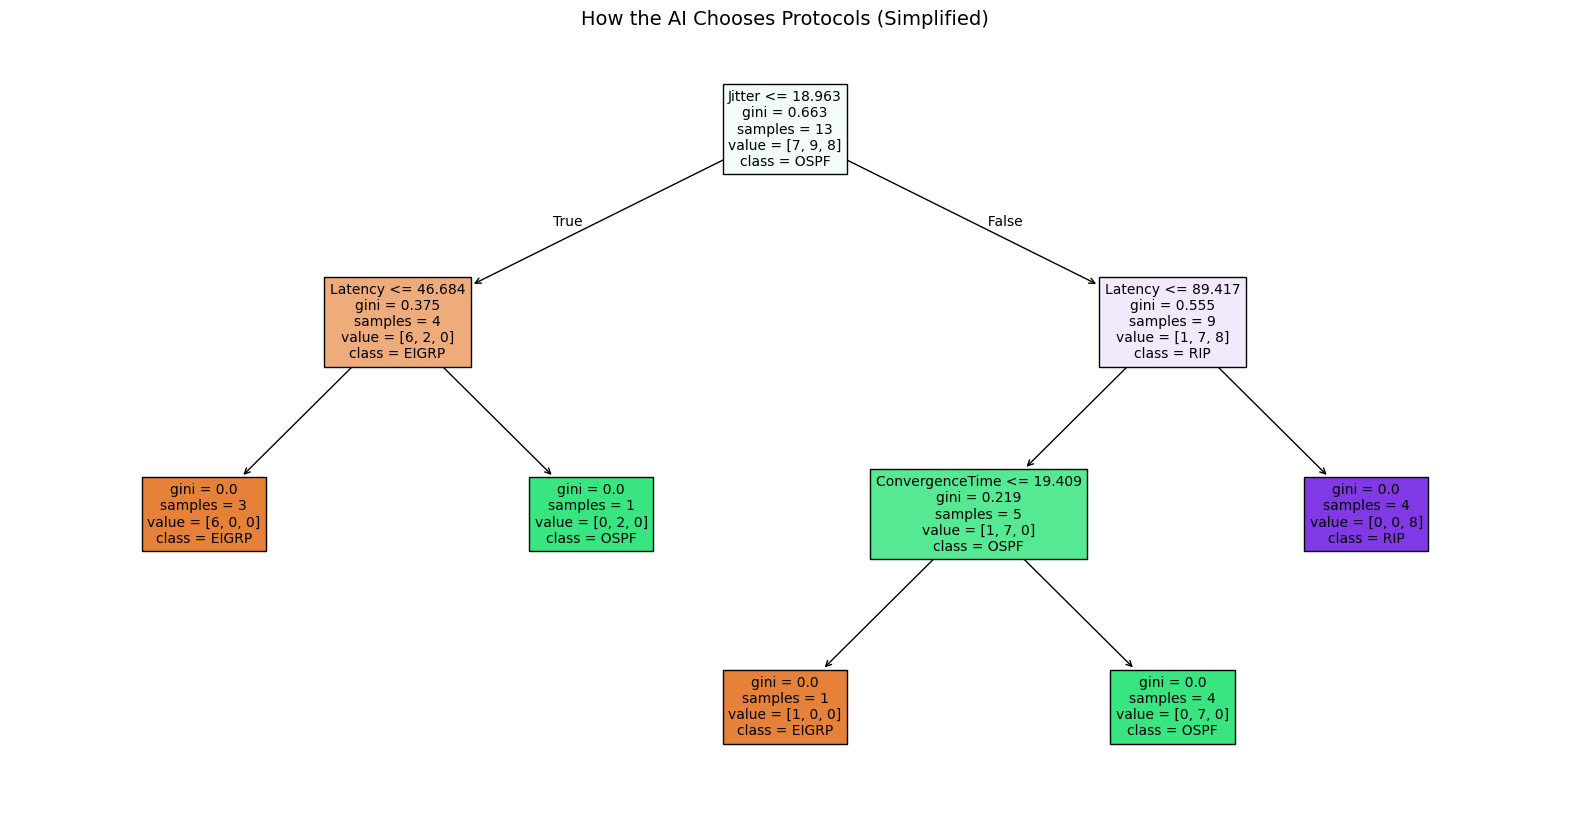

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    model.estimators_[0],  # First tree in the RandomForest
    feature_names=X.columns,  # Shows Latency/Jitter/etc.
    class_names=model.classes_,  # RIP/OSPF/EIGRP
    filled=True,  # Color-codes by protocol
    max_depth=3,  # Limit to 3 levels for readability
    fontsize=10
)
plt.title("How the AI Chooses Protocols (Simplified)", fontsize=14)
plt.savefig(visual_dir / 'decision_tree.png', dpi=300, bbox_inches='tight')  # Save for slides
plt.show()

###  Saved all metrics to: `visual\all_metrics_comparison.png`

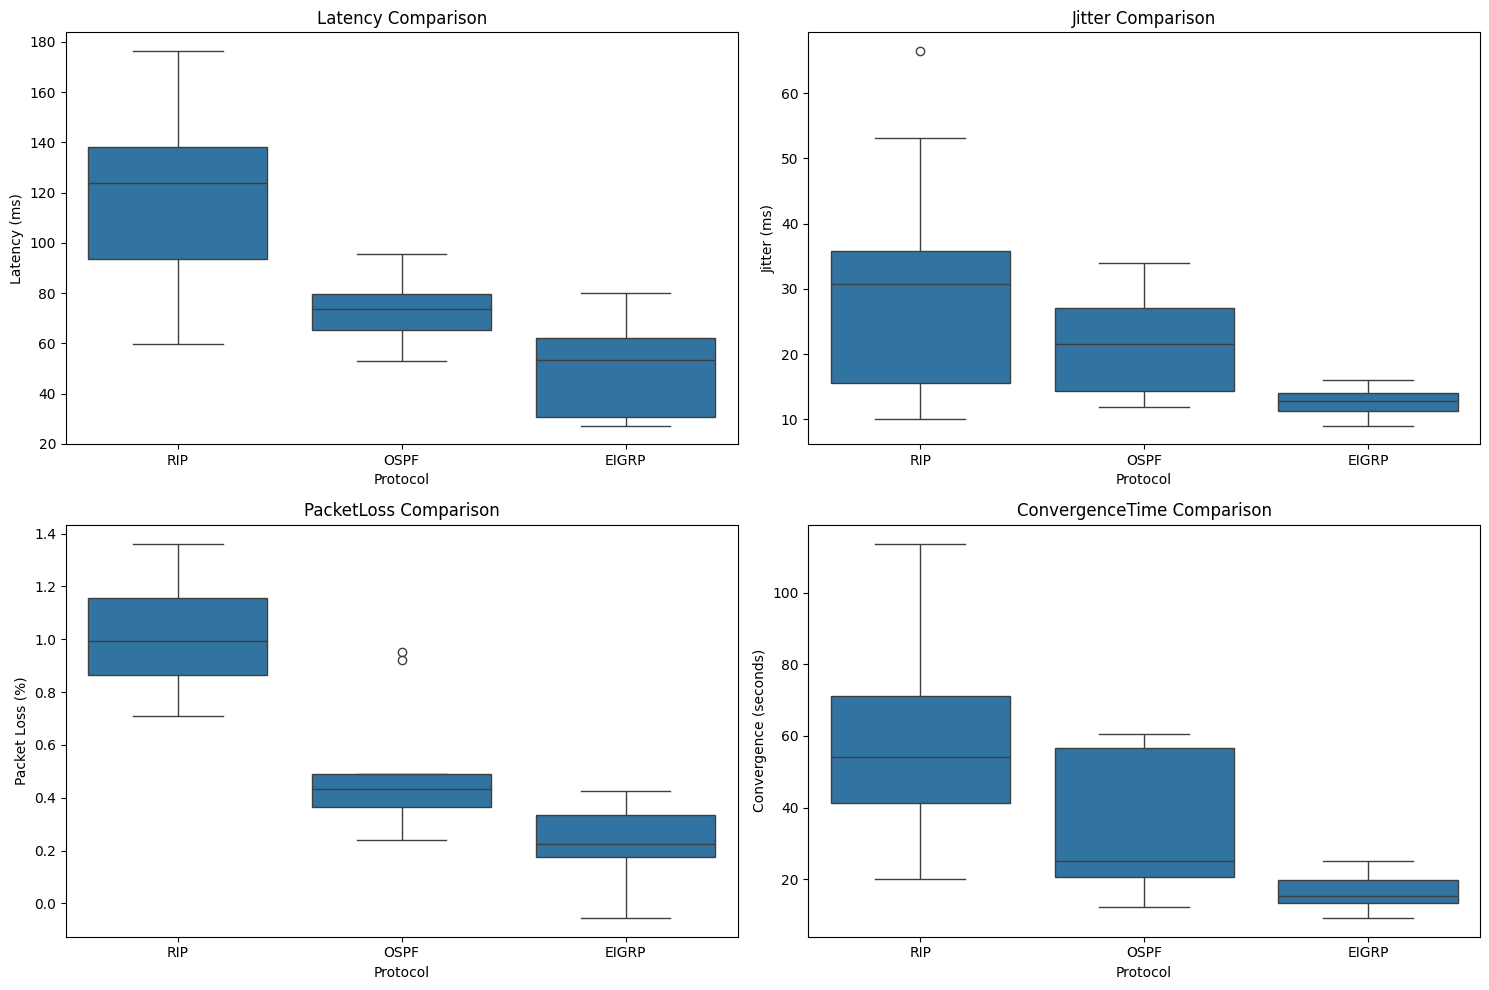

In [16]:
import seaborn as sns
from pathlib import Path

# 1. Ensure visual folder exists
visual_dir = Path('visual')
visual_dir.mkdir(exist_ok=True)

# 2. Create all four metric comparisons
metrics = ['Latency', 'Jitter', 'PacketLoss', 'ConvergenceTime']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Protocol', y=metric, data=df)
    
    # Customize based on metric
    if metric == 'PacketLoss':
        plt.ylabel("Packet Loss (%)")
    elif metric == 'ConvergenceTime':
        plt.ylabel("Convergence (seconds)")
    else:
        plt.ylabel(f"{metric} (ms)")
    
    plt.title(f"{metric} Comparison")

# 3. Save the combined plot
try:
    comparison_path = visual_dir / 'all_metrics_comparison.png'
    plt.tight_layout()
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    display(Markdown(f"###  Saved all metrics to: `{comparison_path}`"))
except Exception as e:
    plt.savefig('all_metrics_backup.png')
    display(Markdown("###  Saved to notebook directory as backup"))

plt.show()

Cross-Validation Accuracy: 0.80 (±0.07)


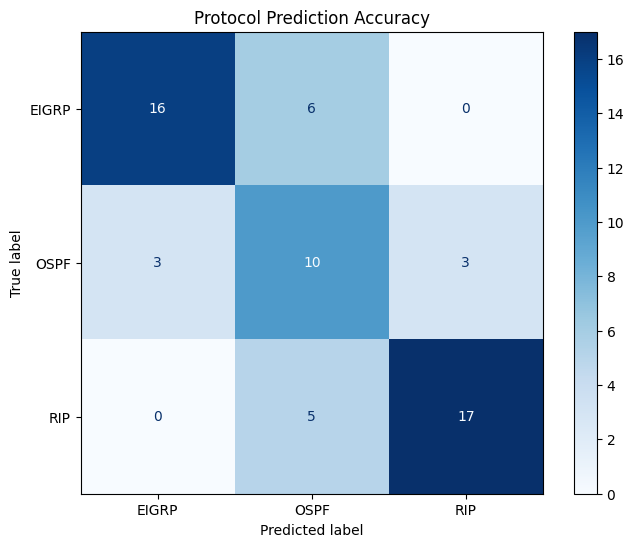

,Feature,Importance
3,ConvergenceTime,0.435666
2,PacketLoss,0.292822
0,Latency,0.140182
1,Jitter,0.131330


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

# 2. Confusion Matrix
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, cmap='Blues')
plt.title("Protocol Prediction Accuracy")
plt.savefig(visual_dir / 'confusion_matrix.png', bbox_inches='tight')  # Saves automatically
plt.show()

# 3. Feature Importance
pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

In [37]:
# ====== MODEL LOADER ====== #
def load_or_train_model():
    """Smart model loader with fallback to training"""
    model_path = project_root / 'models' / 'protocol_classifier.joblib'
    
    try:
        model = joblib.load(model_path)
        print(f"Loaded pre-trained model from {model_path}")
        return model
    except Exception as e:
        print(f"⚠️ Model loading failed ({str(e)}). Training new model...")
        
        # Reuse existing dataset
        X = df[['Latency','Jitter','PacketLoss','ConvergenceTime']]
        y = df['Protocol']
        
        model = RandomForestClassifier(random_state=42)
        model.fit(X, y)
        return model

# Initialize model for recommendation engine
model = load_or_train_model()

Loaded pre-trained model from E:\RoutingOptimizerProject\notebooks\models\protocol_classifier.joblib


In [40]:
import warnings
import ipywidgets as widgets
from IPython.display import display, Markdown, HTML
warnings.filterwarnings('ignore', category=UserWarning)

# Enhanced protocol recommendation function
def recommend_protocol(latency=50, jitter=20, packet_loss=0.5, convergence=20, 
                      cisco_only=False, large_network=False, admin_preference='None',
                      explanation_level='Technical'):
    """
    Next-gen protocol advisor with:
    - Real-time network analysis
    - Constraint-aware recommendations
    - Multi-level technical explanations
    - Configuration guidance
    """
    # Input validation and prediction
    input_data = [[latency, jitter, packet_loss, convergence]]
    
    try:
        # Attempt model prediction
        predicted = model.predict(input_data)[0]
        prediction_confidence = max(model.predict_proba(input_data)[0])
        confidence_note = f" (Confidence: {prediction_confidence:.0%})"
    except Exception as e:
        print(f" Model prediction failed: {str(e)}")
        predicted = None
        confidence_note = ""
    
    # ====== ENHANCED FALLBACK SYSTEM ====== #
    if predicted is None or model is None:
        scoring = {
            'RIP': -latency*0.6 - jitter*0.4,
            'OSPF': -packet_loss*0.8 - convergence*0.2,
            'EIGRP': -latency*0.3 - convergence*0.7
        }
        predicted = max(scoring.keys(), key=lambda x: scoring[x])
        confidence_note = " (Fallback scoring)"
    
    # Comprehensive protocol database
    protocol_db = {
        'RIP': {
            'max_routers': 15,
            'vendor_neutral': True,
            'performance': {
                'latency': 'high (50-150ms)',
                'convergence': 'slow (30-180s)',
                'scalability': 'poor'
            },
            'summary': "Distance-vector protocol for small networks",
            'technical': "Uses hop-count metric with 15-hop limit\nPeriodic full routing table updates every 30s",
            'pros': [
                "Simple configuration",
                "Minimal CPU/memory requirements",
                "Universal vendor support"
            ],
            'cons': [
                "No bandwidth awareness",
                "Slow convergence after failures",
                "Flat network design"
            ],
            'config': [
                "router rip",
                "version 2",
                "network 192.168.1.0",
                "no auto-summary"
            ],
            'use_case': "Small branch offices with <5 routers"
        },
        'OSPF': {
            'max_routers': float('inf'),
            'vendor_neutral': True,
            'performance': {
                'latency': 'medium (20-80ms)',
                'convergence': 'fast (5-40s)',
                'scalability': 'excellent'
            },
            'summary': "Hierarchical link-state protocol",
            'technical': "Dijkstra's SPF algorithm\nArea-based design with LSAs\nDR/BDR election for efficiency",
            'pros': [
                "Fast convergence",
                "Bandwidth-aware routing",
                "Supports network segmentation"
            ],
            'cons': [
                "Complex configuration",
                "High memory usage",
                "Area design critical"
            ],
            'config': [
                "router ospf 1",
                "network 10.0.0.0 0.255.255.255 area 0",
                "auto-cost reference-bandwidth 10000",
                "passive-interface default"
            ],
            'use_case': "Enterprise networks with 10+ routers"
        },
        'EIGRP': {
            'max_routers': float('inf'),
            'vendor_neutral': False,
            'performance': {
                'latency': 'low (10-50ms)',
                'convergence': 'very fast (1-10s)',
                'scalability': 'excellent'
            },
            'summary': "Cisco's advanced hybrid protocol",
            'technical': "DUAL diffusing update algorithm\nComposite metric (bandwidth, delay, reliability, load)\nSuccessor/feasible successor paths",
            'pros': [
                "Sub-second convergence",
                "Minimal network overhead",
                "Supports unequal-cost load balancing"
            ],
            'cons': [
                "Cisco proprietary",
                "Complex metric tuning",
                "Limited visibility in mixed environments"
            ],
            'config': [
                "router eigrp 100",
                "network 10.0.0.0",
                "metric weights 0 1 0 1 0 0",
                "eigrp stub connected"
            ],
            'use_case': "Cisco-only datacenter environments"
        }
    }

    # Protocol filtering logic
    viable_protocols = []
    for proto, data in protocol_db.items():
        exclude = False
        if large_network and proto == 'RIP':
            exclude = True
        if cisco_only and not data['vendor_neutral']:
            viable_protocols.append(proto)
        elif not exclude:
            viable_protocols.append(proto)

    # Recommendation engine
    if admin_preference != 'None' and admin_preference in viable_protocols:
        final_recommendation = admin_preference
        override_note = " (Admin override)"
    elif predicted in viable_protocols:
        final_recommendation = predicted
        override_note = ""
    else:
        scoring = {
            'RIP': -latency * 0.6 - jitter * 0.4,
            'OSPF': -packet_loss * 0.8 - convergence * 0.2,
            'EIGRP': -latency * 0.3 - convergence * 0.7
        }
        final_recommendation = max(viable_protocols, key=lambda x: scoring[x])
        override_note = " (Optimized fallback)"

    # Explanation builder
    selection_factors = []
    if predicted != final_recommendation:
        if large_network and final_recommendation != 'RIP':
            selection_factors.append(f"• RIP excluded: Not suitable for large networks")
        if cisco_only and final_recommendation == 'EIGRP':
            selection_factors.append("• EIGRP preferred: Cisco environment detected")
    
    # Dynamic output generation
    output = []
    output.append(f"##  Recommended Protocol: {final_recommendation}{override_note}")
    
    if explanation_level in ['Technical', 'Full']:
        output.append(f"###  Technical Analysis")
        output.append(f"{protocol_db[final_recommendation]['technical']}")
        output.append(f"**Key Advantages:**")
        output.append("\n".join([f"- {p}" for p in protocol_db[final_recommendation]['pros']]))
        output.append(f"\n**Considerations:**")
        output.append("\n".join([f"- {c}" for c in protocol_db[final_recommendation]['cons']]))
    
    if explanation_level == 'Full':
        output.append(f"###  Configuration Guide")
        output.append("```\n" + "\n".join(protocol_db[final_recommendation]['config']) + "\n```")
        output.append(f"###  Performance Profile")
        output.append(f"- **Typical Latency:** {protocol_db[final_recommendation]['performance']['latency']}")
        output.append(f"- **Convergence Time:** {protocol_db[final_recommendation]['performance']['convergence']}")
        output.append(f"- **Best For:** {protocol_db[final_recommendation]['use_case']}")
    
    if selection_factors:
        output.append(f"###  Selection Notes")
        output.append("\n".join(selection_factors))
    
    return Markdown("\n\n".join(output))

# Enhanced UI Components
def create_slider(title, min_val, max_val, step, default):
    return widgets.FloatSlider(
        value=default,
        min=min_val,
        max=max_val,
        step=step,
        description=title,
        continuous_update=False,
        style={'description_width': '150px'},
        layout={'width': '400px'}
    )

# Create widgets
latency_slider = create_slider("Latency (ms)", 5, 200, 5, 50)
jitter_slider = create_slider("Jitter (ms)", 1, 100, 1, 20)
packet_loss_slider = create_slider("Packet Loss (%)", 0.1, 5.0, 0.1, 0.5)
convergence_slider = create_slider("Convergence (s)", 1, 60, 1, 20)

cisco_checkbox = widgets.Checkbox(
    value=False,
    description='Cisco-only Environment',
    indent=False,
    layout={'width': '250px'}
)

large_network_checkbox = widgets.Checkbox(
    value=False,
    description='Large Network (>15 routers)',
    indent=False,
    layout={'width': '250px'}
)

admin_dropdown = widgets.Dropdown(
    options=['None', 'RIP', 'OSPF', 'EIGRP'],
    value='None',
    description='Admin Preference:',
    style={'description_width': '150px'},
    layout={'width': '300px'}
)

explanation_radio = widgets.RadioButtons(
    options=['Technical', 'Full'],
    value='Technical',
    description='Detail Level:',
    style={'description_width': '150px'}
)

# UI Layout
controls_left = widgets.VBox([
    widgets.Label(" Network Metrics", style={'font_weight': 'bold'}),
    latency_slider,
    jitter_slider,
    packet_loss_slider,
    convergence_slider
], layout={'margin': '0 0 20px 0'})

controls_right = widgets.VBox([
    widgets.Label(" Network Constraints", style={'font_weight': 'bold'}),
    cisco_checkbox,
    large_network_checkbox,
    widgets.HBox([admin_dropdown]),
    widgets.HBox([explanation_radio])
], layout={'margin': '0 0 20px 0'})

# Output area with clear styling
output_area = widgets.Output(layout={
    'border': '1px solid #ddd',
    'padding': '10px',
    'margin': '20px 0',
    'max_width': '800px'
})

# Interactive binding
def update_recommendation(**kwargs):
    with output_area:
        output_area.clear_output()
        display(recommend_protocol(**kwargs))

widgets.interactive(
    update_recommendation,
    latency=latency_slider,
    jitter=jitter_slider,
    packet_loss=packet_loss_slider,
    convergence=convergence_slider,
    cisco_only=cisco_checkbox,
    large_network=large_network_checkbox,
    admin_preference=admin_dropdown,
    explanation_level=explanation_radio
)

# Final display
display(widgets.VBox([
    widgets.HTML("<h1 style='color: #2e86c1'>🌐 Network Protocol Advisor</h1>"),
    widgets.HBox([controls_left, controls_right]),
    widgets.HTML("<h3 style='margin-top: 20px'>💡 Recommendation</h3>"),
    output_area
]))